<a href="https://colab.research.google.com/github/kainatfatima2112/Brain-Tumor-Classification/blob/main/Brain_Tumor_Classify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---



# **Brain Tumor Classification**


---


This project trains on images of Brain MRI scans and then classifies each image into one of the following four categories:

*   Glioma Tumor
*   Meningioma Tumor
*   Pituitary Tumor
*   No Tumor


---



fatal: destination path 'Brain-MRI-Classification' already exists and is not an empty directory.


### Import libraries

In [ ]:
# Import libraries

import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,ImageDataGenerator, array_to_img
from tensorflow.keras.applications import EfficientNetB1

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten,Dense,Conv2D,Dropout,GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
import imutils


### Create directories

In [1]:
# Create Directory for Training Data

import os

# Define main directory and categories
base_dir = "/content/Crop-Brain-MRI"
categories = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]

# Create directories safely
os.makedirs(base_dir, exist_ok=True)
for category in categories:
    os.makedirs(os.path.join(base_dir, category), exist_ok=True)


In [2]:
# Create Directory for Testing Data

import os

# Define main testing directory and categories
test_base_dir = "/content/Test-Brain-MRI"
categories = ["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"]

# Create directories safely
os.makedirs(test_base_dir, exist_ok=True)
for category in categories:
    os.makedirs(os.path.join(test_base_dir, category), exist_ok=True)


### Data Visualisation

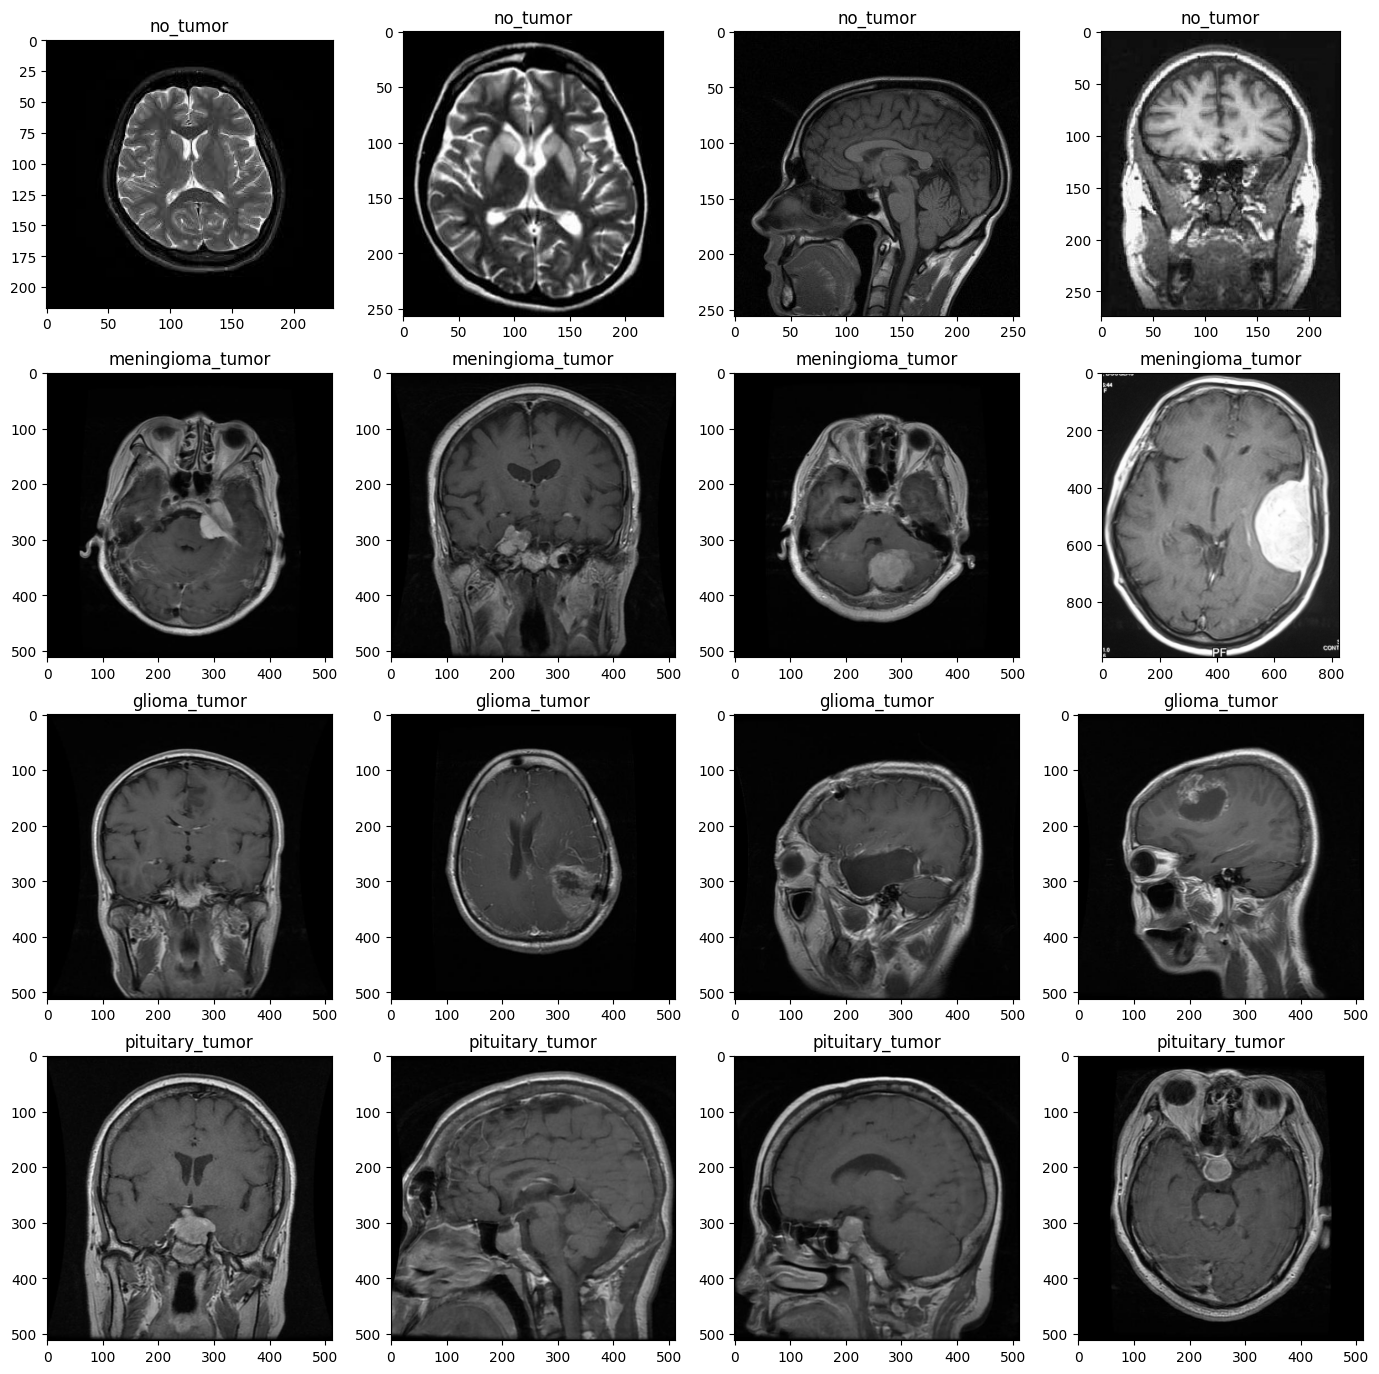

In [ ]:
# Data Visualisation

train_dir = "/content/Brain-MRI-Classification/Brain-MRI/Training/"
test_dir = "/content/Brain-MRI-Classification/Brain-MRI/Testing/"

classes = os.listdir("/content/Brain-MRI-Classification/Brain-MRI/Training")

files_path_dict = {}

for c in classes:
  files_path_dict[c] = list(map(lambda x :train_dir+c+'/'+x, os.listdir(train_dir+c)))

plt.figure(figsize=(17,17))
index = 0

for c in classes:
  random.shuffle(files_path_dict[c])
  path_list = files_path_dict[c][:5]

  for i in range (1,5):
    index += 1
    plt.subplot(4, 4, index)
    plt.imshow(load_img(path_list[i]))
    plt.title(c)



### Crop and Save images

In [ ]:
# Function to crop images

def crop_image(image, plot=False):

    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.GaussianBlur(img_gray, (5, 5), 0)

    img_thresh = cv2.threshold(img_gray, 45, 255, cv2.THRESH_BINARY)[1]
    img_thresh = cv2.erode(img_thresh, None, iterations=2)
    img_thresh = cv2.dilate(img_thresh, None, iterations=2)

    contours = cv2.findContours(img_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    c = max(contours, key=cv2.contourArea)

    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()

    return new_image


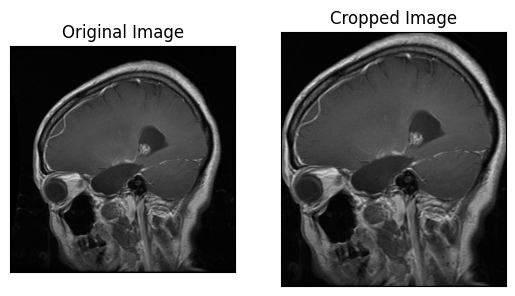

In [ ]:
# Check the crop

example_img = cv2.imread("/content/Brain-MRI-Classification/Brain-MRI/Training/glioma_tumor/gg (101).jpg")
cropped_image_example = crop_image(example_img, plot=True)

In [ ]:
# Crop the Training Images and Save to respective directories
import os # Import os here
from tqdm import tqdm # Import tqdm here
import cv2 # Import cv2 here

train_dir = "/content/Brain-MRI-Classification/Brain-MRI/Training/" # Defined train_dir here
glioma = train_dir + "glioma_tumor"
meningioma = train_dir + "meningioma_tumor"
no_tumor = train_dir + "no_tumor"
pituitary = train_dir + "pituitary_tumor"

j = 0
for i in tqdm(os.listdir(glioma)):
  path = os.path.join(glioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "/content/Crop-Brain-MRI/glioma_tumor/"+ str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j = j+1

j = 0
for i in tqdm(os.listdir(meningioma)):
  path = os.path.join(meningioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "/content/Crop-Brain-MRI/meningioma_tumor/" +str(j) +".jpg"
    cv2.imwrite(save_path, img)
    j = j+1

j = 0
for i in tqdm(os.listdir(no_tumor)):
  path = os.path.join(no_tumor, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224,224))
    save_path = "/content/Crop-Brain-MRI/no_tumor/"+str(j)+".jpg" # Fixed here
    cv2.imwrite(save_path, img)
    j = j+1

j = 0
for i in tqdm(os.listdir(pituitary)):
  path = os.path.join(pituitary, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224,224))
    save_path = "/content/Crop-Brain-MRI/pituitary_tumor/"+str(j)+".jpg" # Fixed here
    cv2.imwrite(save_path, img)
    j = j + 1

100%|██████████| 901/901 [00:02<00:00, 320.59it/s]


In [ ]:
# Crop the Testing Images and Save to respective directories
import os # Import os here
from tqdm import tqdm # Import tqdm here
import cv2 # Import cv2 here

test_dir = "/content/Brain-MRI-Classification/Brain-MRI/Testing/" # Defined test_dir here
glioma = test_dir + "glioma_tumor"
meningioma = test_dir + "meningioma_tumor"
no_tumor = test_dir + "no_tumor"
pituitary = test_dir + "pituitary_tumor"

j = 0
for i in tqdm(os.listdir(glioma)):
  path = os.path.join(glioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "/content/Test-Brain-MRI/glioma_tumor/"+ str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j = j+1

j = 0
for i in tqdm(os.listdir(meningioma)):
  path = os.path.join(meningioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "/content/Test-Brain-MRI/meningioma_tumor/" +str(j) +".jpg"
    cv2.imwrite(save_path, img)
    j = j+1

j = 0
for i in tqdm(os.listdir(no_tumor)):
  path = os.path.join(no_tumor, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224,224))
    save_path = "/content/Test-Brain-MRI/no_tumor/"+str(j)+".jpg" # Fixed here
    cv2.imwrite(save_path, img)
    j = j+1

j = 0
for i in tqdm(os.listdir(pituitary)):
  path = os.path.join(pituitary, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224,224))
    save_path = "/content/Test-Brain-MRI/pituitary_tumor/"+str(j)+".jpg" # Fixed here
    cv2.imwrite(save_path, img)
    j = j + 1

100%|██████████| 5/5 [00:00<00:00, 186.61it/s]


### Perform Data Augmentation and Prepare the Train, Validation, and Test Dataset

In [ ]:
# Use Image Data Generator

datagen = ImageDataGenerator(rotation_range=10, height_shift_range=0.2, horizontal_flip=True, validation_split=0.2)
train_data = datagen.flow_from_directory('/content/Crop-Brain-MRI/', target_size=(224,224), batch_size=32, class_mode='categorical', subset='training')

valid_data = datagen.flow_from_directory('/content/Crop-Brain-MRI/', target_size=(224,224), batch_size=32, class_mode='categorical', subset='validation')

test_datagen = ImageDataGenerator()

test_data = datagen.flow_from_directory('/content/Test-Brain-MRI/', target_size=(224,224), class_mode='categorical')


Found 2613 images belonging to 4 classes.
Found 652 images belonging to 4 classes.
Found 20 images belonging to 4 classes.


In [ ]:
# View the class dictionary

print(train_data.class_indices)
print(test_data.class_indices)

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


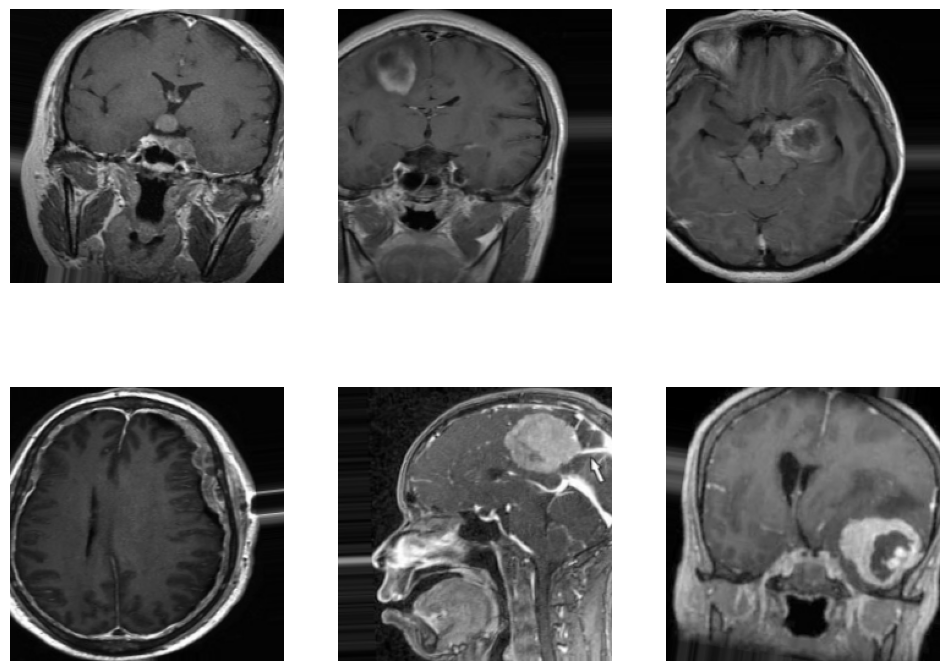

In [ ]:
# View the augmented data

sample_x, sample_y =next(train_data)
plt.figure(figsize=(12,9))
for i in range (6):
  plt.subplot(2, 3, i+1)
  sample = array_to_img(sample_x[i])
  plt.axis('off')
  plt.grid(False)
  plt.imshow(sample)
plt.show()


### Build and Compile the model

In [ ]:
# Build the Model

effnet = EfficientNetB1(weights="imagenet", include_top=False, input_shape=(224,224, 3))

model = effnet.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(4, activation="softmax")(model)
model = Model(inputs= effnet.input, outputs=model)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_4         │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_2     │ (None, 224, 224,  │          7 │ rescaling_4[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_5         │ (None, 224, 224,  │          0 │ normalization_2[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_5[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 6,580,363 (25.10 MB)

 Trainable params: 6,518,308 (24.87 MB)

 Non-trainable params: 62,055 (242.41 KB)

In [ ]:
# Compile the model

model.compile(
    optimizer=Adam(learning_rate=0.0001),  # use `learning_rate` instead of deprecated `lr`
    loss="categorical_crossentropy",
    metrics=["accuracy"]) # Added closing parenthesis here
checkpoint = ModelCheckpoint(
    "model.h5",
    monitor="val_accuracy",
    save_best_only=True,
    mode="auto",
    verbose=1
)

earlystop = EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    mode="auto",
    verbose=1
)

### Train and Evaluate the model

In [ ]:
# Train the model

# Clone the repository
!git clone https://github.com/nazianafis/Brain-MRI-Classification.git

# Import necessary libraries
import os # Import os here
from tqdm import tqdm # Import tqdm here
import cv2 # Import cv2 here
import numpy as np # Import numpy here
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Import ImageDataGenerator
import imutils # Import imutils here
import time # Import time for potential delay

# Check if the repository is cloned
if not os.path.exists("/content/Brain-MRI-Classification/Brain-MRI/Training"):
    print("Cloning failed or took too long. Please check the git clone command or run it manually.")
    # Optionally add a small delay and recheck, or exit
    # time.sleep(10)
    # if not os.path.exists("/content/Brain-MRI-Classification/Brain-MRI/Training"):
    #   exit()


# Create Directory for Training Data
if not os.path.exists("/content/Crop-Brain-MRI"):
    os.mkdir("/content/Crop-Brain-MRI")
    os.mkdir("/content/Crop-Brain-MRI/glioma_tumor")
    os.mkdir("/content/Crop-Brain-MRI/meningioma_tumor")
    os.mkdir("/content/Crop-Brain-MRI/no_tumor")
    os.mkdir("/content/Crop-Brain-MRI/pituitary_tumor")

# Create Directory for Testing Data
if not os.path.exists("/content/Test-Brain-MRI"):
    os.mkdir("/content/Test-Brain-MRI")
    os.mkdir("/content/Test-Brain-MRI/glioma_tumor")
    os.mkdir("/content/Test-Brain-MRI/meningioma_tumor")
    os.mkdir("/content/Test-Brain-MRI/no_tumor")
    os.mkdir("/content/Test-Brain-MRI/pituitary_tumor")

# Function to crop images
def crop_image(image, plot=False):

    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.GaussianBlur(img_gray, (5, 5), 0)

    img_thresh = cv2.threshold(img_gray, 45, 255, cv2.THRESH_BINARY)[1]
    img_thresh = cv2.erode(img_thresh, None, iterations=2)
    img_thresh = cv2.dilate(img_thresh, None, iterations=2)

    contours = cv2.findContours(img_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    c = max(contours, key=cv2.contourArea)

    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()

    return new_image

# Crop the Training Images and Save to respective directories
train_dir = "/content/Brain-MRI-Classification/Brain-MRI/Training/" # Defined train_dir here
glioma = train_dir + "glioma_tumor"
meningioma = train_dir + "meningioma_tumor"
no_tumor = train_dir + "no_tumor"
pituitary = train_dir + "pituitary_tumor"

j = 0
for i in tqdm(os.listdir(glioma)):
  path = os.path.join(glioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "/content/Crop-Brain-MRI/glioma_tumor/"+ str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j = j+1

j = 0
for i in tqdm(os.listdir(meningioma)):
  path = os.path.join(meningioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "/content/Crop-Brain-MRI/meningioma_tumor/" +str(j) +".jpg"
    cv2.imwrite(save_path, img)
    j = j+1

j = 0
for i in tqdm(os.listdir(no_tumor)):
  path = os.path.join(no_tumor, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224,224))
    save_path = "/content/Crop-Brain-MRI/no_tumor/"+str(j)+".jpg" # Fixed here
    cv2.imwrite(save_path, img)
    j = j+1

j = 0
for i in tqdm(os.listdir(pituitary)):
  path = os.path.join(pituitary, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224,224))
    save_path = "/content/Crop-Brain-MRI/pituitary_tumor/"+str(j)+".jpg" # Fixed here
    cv2.imwrite(save_path, img)
    j = j + 1

# Crop the Testing Images and Save to respective directories
test_dir = "/content/Brain-MRI-Classification/Brain-MRI/Testing/" # Defined test_dir here
glioma = test_dir + "glioma_tumor"
meningioma = test_dir + "meningioma_tumor"
no_tumor = test_dir + "no_tumor"
pituitary = test_dir + "pituitary_tumor"

j = 0
for i in tqdm(os.listdir(glioma)):
  path = os.path.join(glioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "/content/Test-Brain-MRI/glioma_tumor/"+ str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j = j+1

j = 0
for i in tqdm(os.listdir(meningioma)):
  path = os.path.join(meningioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "/content/Test-Brain-MRI/meningioma_tumor/" +str(j) +".jpg"
    cv2.imwrite(save_path, img)
    j = j+1

j = 0
for i in tqdm(os.listdir(no_tumor)):
  path = os.path.join(no_tumor, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224,224))
    save_path = "/content/Test-Brain-MRI/no_tumor/"+str(j)+".jpg" # Fixed here
    cv2.imwrite(save_path, img)
    j = j+1

j = 0
for i in tqdm(os.listdir(pituitary)):
  path = os.path.join(pituitary, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224,224))
    save_path = "/content/Test-Brain-MRI/pituitary_tumor/"+str(j)+".jpg" # Fixed here
    cv2.imwrite(save_path, img)
    j = j + 1


# Use Image Data Generator
datagen = ImageDataGenerator(rotation_range=10, height_shift_range=0.2, horizontal_flip=True, validation_split=0.2)
train_data = datagen.flow_from_directory('/content/Crop-Brain-MRI/', target_size=(224,224), batch_size=32, class_mode='categorical', subset='training')
valid_data = datagen.flow_from_directory('/content/Crop-Brain-MRI/', target_size=(224,224), batch_size=32, class_mode='categorical', subset='validation')


# Build the Model
effnet = EfficientNetB1(weights="imagenet", include_top=False, input_shape=(224,224, 3))

model = effnet.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(4, activation="softmax")(model)
model = Model(inputs= effnet.input, outputs=model)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),loss="categorical_crossentropy",metrics=["accuracy"])
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)

earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto", verbose=1)


history = model.fit(train_data, epochs=7, validation_data=valid_data, verbose=1, callbacks=[checkpoint, earlystop])

fatal: destination path 'Brain-MRI-Classification' already exists and is not an empty directory.


100%|██████████| 5/5 [00:00<00:00, 231.43it/s]

Found 2613 images belonging to 4 classes.
Found 652 images belonging to 4 classes.



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/7
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 990ms/step - accuracy: 0.5221 - loss: 1.0970

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.79755, saving model to model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.5238 - loss: 1.0940 - val_accuracy: 0.7975 - val_loss: 0.5502
Epoch 2/7
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.8753 - loss: 0.3850
Epoch 2: val_accuracy improved from 0.79755 to 0.85736, saving model to model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 93s 519ms/step - accuracy: 0.8754 - loss: 0.3846 - val_accuracy: 0.8574 - val_loss: 0.3885
Epoch 3/7
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.9247 - loss: 0.2336
Epoch 3: val_accuracy improved from 0.85736 to 0.90644, saving model to model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 44s 532ms/step - accuracy: 0.9247 - loss: 0.2334 - val_accuracy: 0.9064 - val_loss: 0.2851
Epoch 4/7
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.9464 - loss: 0.1461
Epoch 4: val_accuracy did not improve from 0.90644
82/82 ━━━━━━━━━━━━━━━━━━━━ 42s 511ms/step - accuracy: 0.9465 - loss: 0.1460 - val_accuracy: 0.8957 - val_loss: 0.2940
Epoch 5/7
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.9663 - loss: 0.1046
Epoch 5: val_accuracy improved from 0.90644 to 0.91564, saving model to model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 44s 533ms/step - accuracy: 0.9662 - loss: 0.1046 - val_accuracy: 0.9156 - val_loss: 0.2309
Epoch 6/7
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.9773 - loss: 0.0802
Epoch 6: val_accuracy improved from 0.91564 to 0.95706, saving model to model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 43s 520ms/step - accuracy: 0.9773 - loss: 0.0802 - val_accuracy: 0.9571 - val_loss: 0.1549
Epoch 7/7
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step - accuracy: 0.9817 - loss: 0.0583
Epoch 7: val_accuracy improved from 0.95706 to 0.96472, saving model to model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 43s 524ms/step - accuracy: 0.9816 - loss: 0.0583 - val_accuracy: 0.9647 - val_loss: 0.1245


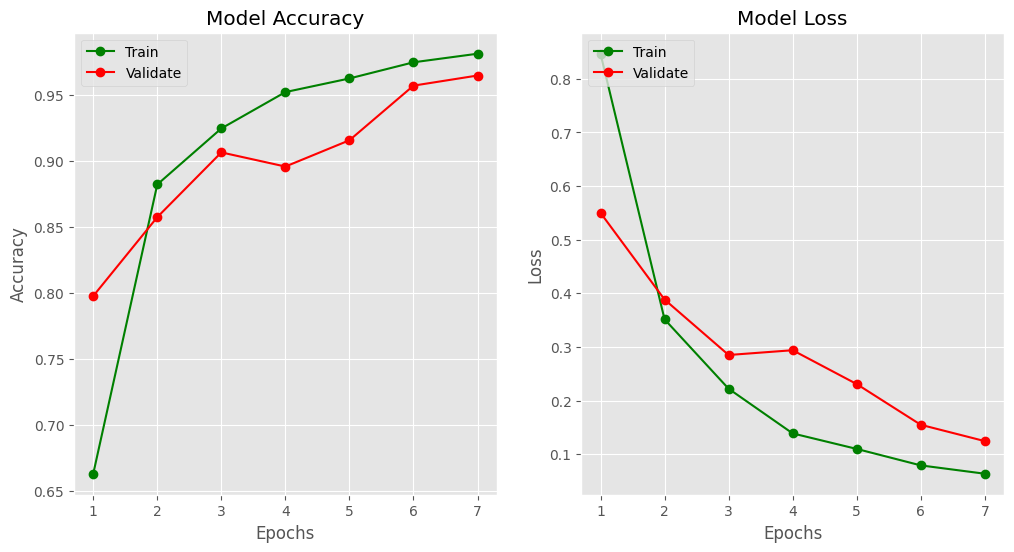

In [ ]:
# Plot the training curves

plt.style.use("ggplot")
plt.figure(figsize=(12,6))
epochs = range(1,8)
plt.subplot(1,2,1)
plt.plot(epochs, history.history["accuracy"], "go-")
plt.plot(epochs, history.history["val_accuracy"], "ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","Validate"], loc="upper left")

plt.subplot(1,2,2)
plt.plot(epochs, history.history["loss"], "go-")
plt.plot(epochs, history.history["val_loss"], "ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","Validate"], loc="upper left")

plt.show()

In [ ]:
# Evaluate the model on Test Set

model.evaluate(test_data)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step - accuracy: 0.3000 - loss: 1.4488


[1.4488446712493896, 0.30000001192092896]

### Obtain Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
glioma_tumor


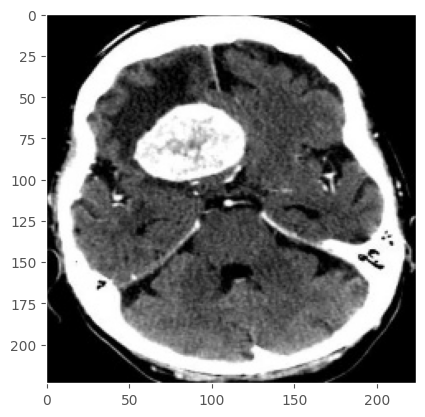

In [ ]:
# Obtain Prediction on Test Image

import cv2 # Import cv2 here
import matplotlib.pyplot as plt # Import matplotlib.pyplot here
import numpy as np # Import numpy here

class_dict = {0: "glioma_tumor", 1: "meningioma_tumor", 2: "no_tumor", 3: "pituitary_tumor"}

test_img1 = cv2.imread("/content/Test-Brain-MRI/meningioma_tumor/4.jpg")

if test_img1 is not None: # Added check for image loading
    plt.imshow(test_img1)
    plt.grid(False)

    test_img1 = np.expand_dims(test_img1, axis=0)

    pred = model.predict(test_img1)
    pred = np.argmax(pred)
    pred_class =class_dict[pred]
    print(pred_class)
else:
    print("Error loading image.") # Added error message